# <p style="text-align:center" color="red"><span style="color:red">`Research Methodologies project`</span></p>
## <p style="text-align:center" color="red"><span style="color:green">ChemNLP: A Natural Language Processing based Library for Materials Chemistry Text Data
</span></p>
## <p style="text-align:center" color="red"><span style="color:red">Part 3 : Refining and Validating Clusters in Condensed Matter: The K-means Clustering Evaluation</span></p>


**Membres du Groupe :**

- Abir Oumghar - `AMSD`
- Meryem Belkaid - `AMSD`
- Hafsa Boanani - `AMSD`



# Testing the Kmeans Clustring - `Cond Mat`

## Import Required Libraries
In this section, we import the necessary libraries that are essential for the operations and analyses to be performed in this notebook.

In [1]:
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# For data processing
import numpy as np
import pandas as pd

# For clustering and dimensionality reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from scipy.spatial.distance import cdist

# Plotly imports
import plotly.graph_objects as go
from plotly.offline import plot

# For Parallel Computing
from joblib import Parallel, delayed

# For evaluation and visualization
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, normalized_mutual_info_score
from tqdm import tqdm
import pickle

# Other imports 
from collections import Counter
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()  # for plot styling

## Loading the Training and Testing Datasets

In our previous notebook, we accomplished the task of embedding document abstracts using the BERT model obtained from Hugging Face. A total of 25,000 documents were processed, for which we also assigned labels and saved the results in a binary pickle file. To manage the extensive computational demand, we divided the embeddings into chunks, applying the embeddings in batches.

Currently, we will proceed to load these embeddings. The initial set of 21,000 documents will serve as our training dataset for a K-means clustering algorithm, post dimensionality reduction using PCA with 2 components. The remaining 4,000 documents will be utilized to evaluate the accuracy of the K-means clustering algorithm.

In [2]:
# Paths to the Embedding files
datasets_paths = {
    'cond_mat_embeddings_with_ids_5000':'cond_mat_embeddings_with_ids_5000.pickle',
    'cond_mat_embeddings_with_ids_10000':'cond_mat_embeddings_with_ids_10000.pickle',
    'cond_mat_embeddings_with_ids_16000': 'cond_mat_embeddings_with_ids_16000.pickle',
    'cond_mat_embeddings_with_ids_16001_21000': 'cond_mat_embeddings_with_ids_16001_21000.pickle',
    'cond_mat_embeddings_with_ids_21001_25000': 'cond_mat_embeddings_with_ids_21001_25000.pickle',
}

# Function to load a dataset
def load_dataset(file_path):       #Systematic Loading
    with open(file_path, 'rb') as file:
        return pickle.load(file)

# Load the train embedding datasets
cond_mat_embeddings_with_ids_5000 = load_dataset(datasets_paths["cond_mat_embeddings_with_ids_5000"])
cond_mat_embeddings_with_ids_10000 = load_dataset(datasets_paths["cond_mat_embeddings_with_ids_10000"])
cond_mat_embeddings_with_ids_16000 = load_dataset(datasets_paths["cond_mat_embeddings_with_ids_16000"])
cond_mat_embeddings_with_ids_16001_21000 = load_dataset(datasets_paths["cond_mat_embeddings_with_ids_16001_21000"])

# Load the test embedding dataset
cond_mat_embeddings_with_ids_21001_25000 = load_dataset(datasets_paths["cond_mat_embeddings_with_ids_21001_25000"])

Thus far, we have simply loaded the pickle files containing the embeddings and labels of our dataset.



## Split the Embedding Data into Train / Test

In [3]:
# Merge the datasets
merged_data_list = cond_mat_embeddings_with_ids_5000['data'] + cond_mat_embeddings_with_ids_10000['data'] + cond_mat_embeddings_with_ids_16000['data'] + cond_mat_embeddings_with_ids_16001_21000['data']

# Spliting the Embeddings Train / Test
embeddings_training_data = {'data': merged_data_list}
embeddings_test_data = {'data': cond_mat_embeddings_with_ids_21001_25000['data']}

In [4]:
# Print dataset information
num_docs_training = len(embeddings_training_data['data'])
num_features_training = len(embeddings_training_data['data'][0]['embedding'])
num_docs_test = len(embeddings_test_data['data'])
num_features_test = len(embeddings_test_data['data'][0]['embedding'])

print(f">> The Embedding Training Dataset has {num_docs_training} documents and {num_features_training} features.")
print(f">> The Embedding Test Dataset has {num_docs_test} documents and {num_features_test} features.")

>> The Embedding Training Dataset has 20997 documents and 768 features.
>> The Embedding Test Dataset has 3999 documents and 768 features.


As mentioned previously, we will utilize 20,997 documents for training the K-means algorithm and 3,999 for testing. However, before proceeding, we will employ PCA to reduce the dimensionality, considering our total feature count is 768.

PCA is applied to mitigate the curse of dimensionality, a well-known concept where the space volume increases, leading to sparse data. This can make clustering algorithms harder to execute effectively.

## Dimensionality Reduction and K-means Clustering

This section of code conducts dimensionality reduction using Principal Component Analysis (PCA) and performs K-means clustering on the document embeddings. The purpose is to demonstrate how dimensionality reduction can aid in visualizing high-dimensional data and how K-means clustering can be applied for document clustering tasks.

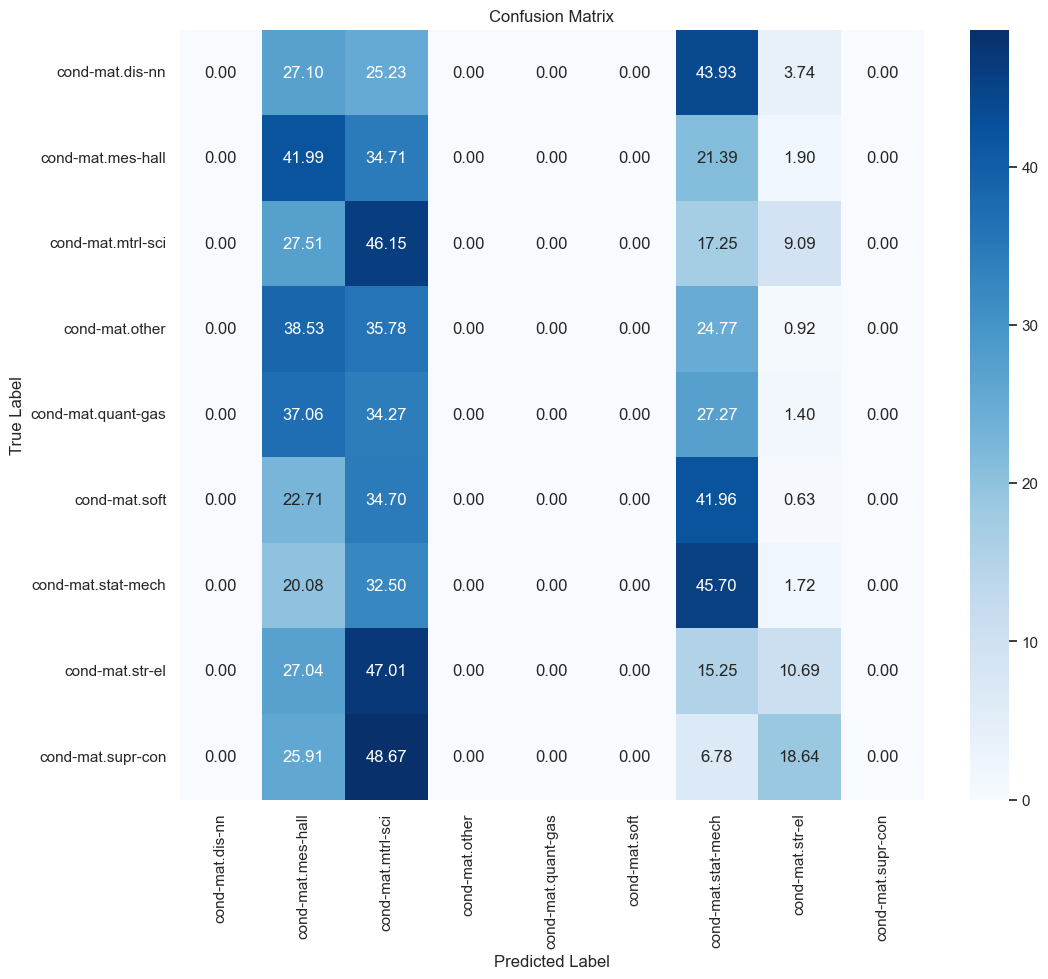

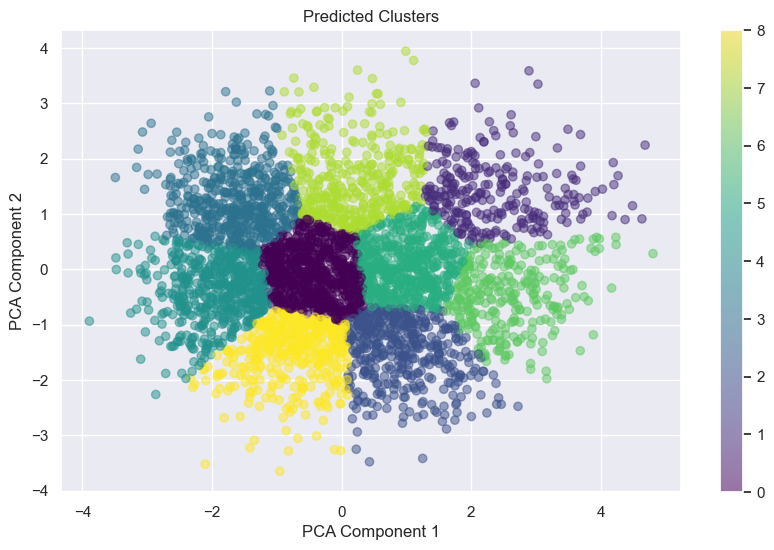

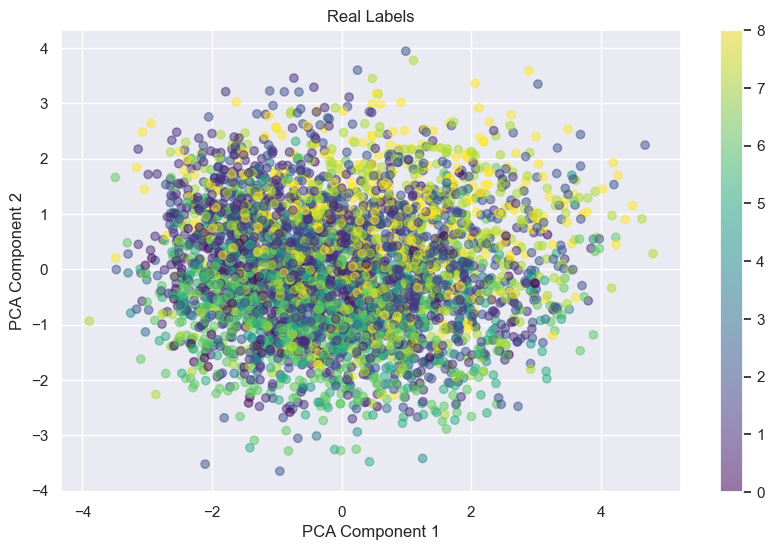

In [5]:
def prepare_embeddings(data):
    """Extract embeddings and labels from the data."""
    embeddings_list = [item['embedding'] for item in data['data']]
    labels = [item['label'] for item in data['data']]
    return np.array(embeddings_list), labels

embeddings_train, labels_train = prepare_embeddings(embeddings_training_data)
embeddings_test, labels_test = prepare_embeddings(embeddings_test_data)

# Apply PCA to reduce to 2 components
pca = PCA(n_components=2, random_state=42)
reduced_embeddings_train_pca = pca.fit_transform(embeddings_train)
reduced_embeddings_test_pca = pca.transform(embeddings_test)

# Train K-means on the training set with the real number of unique labels
n_clusters = len(np.unique(labels_train))
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(reduced_embeddings_train_pca)

# Predict on the test set
predicted_labels_test = kmeans.predict(reduced_embeddings_test_pca)

# Map predicted cluster labels to real class names
def map_clusters_to_labels(kmeans_labels, true_labels):
    label_mapping = {}
    for cluster in np.unique(kmeans_labels):
        # Find the most common true label in each cluster
        index = np.where(kmeans_labels == cluster)[0]
        most_common = Counter(np.array(true_labels)[index]).most_common(1)[0][0]
        label_mapping[cluster] = most_common
    return label_mapping

# Apply mapping to the predicted labels
label_mapping = map_clusters_to_labels(kmeans.labels_, labels_train)
predicted_class_names = [label_mapping[label] for label in predicted_labels_test]

# Visualization
def visualize_clusters(X, labels, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', label=labels, alpha=0.5)
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar()
    plt.show()

def plot_confusion_matrix(true_labels, predicted_labels, classes):
    """Plot the confusion matrix."""
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=classes)
    
    # Calculate percentages
    cm_percent = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100, 2)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

classes = sorted(np.unique(labels_test + predicted_class_names))
plot_confusion_matrix(labels_test, predicted_class_names, classes)

# Visualize predicted vs real labels
visualize_clusters(reduced_embeddings_test_pca, predicted_labels_test, 'Predicted Clusters')
visualize_clusters(reduced_embeddings_test_pca, [np.where(np.unique(labels_test) == label)[0][0] for label in labels_test], 'Real Labels')

s. efforts yield similar results.

#### PCA Scatter Plot Interpretation

The scatter plot illuminates the distribution of the Cond Mat Test dataset across its first two principal components post PCA dimensionality reduction. Key insights are as follows:

- **Data Spread**: The points demonstrate a spread across the PCA components, signifying captured variation within the dataset.
- **Cluster Overlap**: Notably, there's significant overlap among classes, indicating ambiguous clustering boundaries.
- **PCA Components**: PCA Component 1 (x-axis) and PCA Component 2 (y-axis) illustrate the axes of maximum variance within the data.
- **Color Encoding**: The colors assigned to points represent their true labels, facilitating class identification.

This visualization accentuates the complexity of the dataset and the challenges it presents to clustering algorithms like K-Means, a fact corroborated by the subsequent analysis of the confusion matrix.

#### Insights from the Confusion Matrix

The confusion matrix provides valuable insights into the performance of the classification model:

- **Diagonal Values**: These values highlight the percentage of correctly classified instances for each true label. For instance, `cond-mat.dis-nn` attains the highest correct classification rate at approximately 43.93%, while `cond-mat.supr-con` achieves 48.67% correct classification.
- **Off-Diagonal Values**: Represent misclassifications, offering insight into common errors made by the classifier. For example, `cond-mat.dis-nn` is frequently misclassified as `cond-mat.mes-hall` (27.10%) and `cond-mat.stat-mech` (25.23%).
- **Zero Values**: The presence of zero misclassifications in several cells indicates instances where specific combinations experienced no misclassification.
- **Class Confusion**: Certain classes demonstrate a tendency to be confused with others, suggesting potential similarities or ambiguities between them.

#### Conclusion and Recommendations

The analysis of both the Confusion Matrix and Scatter Plot reveals that PCA-based dimensionality reduction fails to demarcate distinct clusters, leading to significant class overlaps. This indicates that the K-means clustering algorithm faces challenges in delineating clear groupings within the data. To address these challenges, it may be beneficial to explore alternative approaches, such as employing advanced embedding algorithms (e.g., BERT, OpenAI techniques), improving text preprocessing methods, or experimenting with other dimensionality reduction techniques like UMAP or t-SNE. Moreover, considering different clustering methods (e.g., DBSCAN, Hierarchical Clustering) might offer new insights, although the effectiveness of these methods is contingent upon the ability to visually distinguish clusters in a reduced-dimensional space.

Understanding the balance between data dimensionality reduction for visualization purposes and the preservation of significant cluster structures is crucial, especially in the context of the Cond Mat Dataset. The author's attempts at advanced processing, including extracting formula names and prioritizing chemical elements, underscore the challenges faced in achieving clear visual differentiation of clusters, highlighting the intricate nature of the data and the limitations of current methodologies.